In [1]:
import sys
import numpy  as np
import pandas as pd

import antea.database.load_db      as db
import antea.reco.reco_functions   as rf
import antea.reco.mctrue_functions as mcf

import matplotlib.pyplot as plt

Analyzing file /Users/carmenromoluque/nexus_petit_analysis/PETit-ring/change_to_dataframes/full_ring_iradius165mm_depth3cm_pitch7mm_new_h5.001.pet.h5
[array([  26.70681 , -183.4894  ,  -20.824465], dtype=float32), array([-26.638657, 184.9117  ,  20.668644], dtype=float32)]


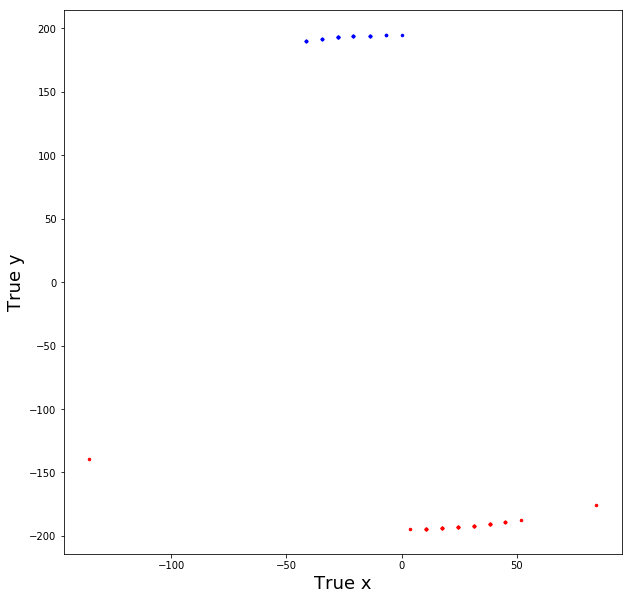

In [2]:
### read sensor positions from database
DataSiPM     = db.DataSiPM('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')

start     = 1
numb      = 1
threshold = 2

eventsPath = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/change_to_dataframes/'
file_name  = 'full_ring_iradius165mm_depth3cm_pitch7mm_new_h5'
data_path  = eventsPath + '/data_test'
file_full  = eventsPath + file_name + '.{0:03d}.pet.h5'
evt_file   = '{0}/full_ring_irad15cm_d3cm_p7mm_reco_info_{1}_{2}'.format(data_path, start, numb)

true_r1, true_r2   = [], []
var_phi1, var_phi2 = [], []
var_z1, var_z2     = [], []

touched_sipms1, touched_sipms2 = [], []

for ifile in range(start, start+numb):

    file_name = file_full.format(ifile)
    try:
        sns_response = pd.read_hdf(file_name, 'MC/waveforms')
    except ValueError:
        print('File {} not found'.format(file_name))
        continue
    except OSError:
        print('File {} not found'.format(file_name))
        continue
    except KeyError:
        print('No object named MC/waveforms in file {0}'.format(file_name))
        continue
    print('Analyzing file {0}'.format(file_name))

    sel_df = rf.find_SiPMs_over_threshold(sns_response, threshold)

    particles = pd.read_hdf(file_name, 'MC/particles')
    hits      = pd.read_hdf(file_name, 'MC/hits')
    events    = particles.event_id.unique()

    for evt in events[831:832]:

        ### Select photoelectric events only
        evt_parts = particles[particles.event_id == evt]
        evt_hits  = hits     [hits     .event_id == evt]

        select, true_pos = mcf.select_photoelectric(evt_parts, evt_hits)
        print(true_pos)

        if not select: continue

        if (len(true_pos) == 1) & (evt_hits.energy.sum() > 0.513):
            continue

        waveforms = sel_df[sel_df.event_id == evt]
        if len(waveforms) == 0: continue

        q1, q2, pos1, pos2 = rf.assign_sipms_to_gammas(waveforms, true_pos, DataSiPM_idx)
        pos1_x = np.array([el[0] for el in pos1])
        pos1_y = np.array([el[1] for el in pos1])
        
        pos2_x = np.array([el[0] for el in pos2])
        pos2_y = np.array([el[1] for el in pos2])
        
        plt.figure(figsize=(10,10))
        plt.plot(pos1_x, pos1_y, '.', c='r', markersize=5)
        plt.plot(pos2_x, pos2_y, '.', c='b', markersize=5)
        plt.xlabel('True x', size=18)
        plt.ylabel('True y', size=18)